- Data cleaning / transformation
- Data visualization

to be predicted: hour, day of week?

methods:
- prophet : https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet#Simple-Prophet-Model
- tsa (arma, arima, sarima)

https://builtin.com/data-science/time-series-forecasting-python

https://www.analyticsvidhya.com/blog/2022/06/time-series-forecasting-using-python/



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import folium
from folium.plugins import MarkerCluster

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import MSTL

import itertools
import warnings

https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.MSTL.html

https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

In [2]:
# Load data from file
data = pd.read_csv('apr-sep14.gzip', compression='gzip')
# View data
data.head()

Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512

In [3]:
# Check clumn types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 138.4+ MB


In [4]:
# Transform the first Date/Time column into a datetime format
data['Date/Time'] = pd.to_datetime(data['Date/Time'])

# View column types again to ensure transformation
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Date/Time  datetime64[ns]
 1   Lat        float64       
 2   Lon        float64       
 3   Base       object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 138.4+ MB


In [5]:
# Check total number of missing values
data.isna().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

In [6]:
# Create column to show number of rides for each entry, this will help in counting total number of rides
data['Rides'] = 1

# Get date
data['Date'] = data['Date/Time'].dt.date

# Create a column showing the month of the year
data['Month'] = data['Date/Time'].dt.month

# Get month abbreviation
data['Month'] = pd.to_datetime(data['Month'], format='%m').dt.month_name().str[:3]

# Create column showing day of month number
data['Day'] = data['Date/Time'].dt.day

# Create column showing hour of day
data['Hour'] = data['Date/Time'].dt.hour

# Get day of week
data['Day of Week'] = data['Date/Time'].dt.dayofweek

# Get week of year
data['Week of year'] = data['Date/Time'].dt.isocalendar().week

# View what Data looks like now
data.head()

Date/Time      Lat      Lon    Base  Rides        Date Month  Day   
0 2014-04-01 00:11:00  40.7690 -73.9549  B02512      1  2014-04-01   Apr    1  \
1 2014-04-01 00:17:00  40.7267 -74.0345  B02512      1  2014-04-01   Apr    1   
2 2014-04-01 00:21:00  40.7316 -73.9873  B02512      1  2014-04-01   Apr    1   
3 2014-04-01 00:28:00  40.7588 -73.9776  B02512      1  2014-04-01   Apr    1   
4 2014-04-01 00:33:00  40.7594 -73.9722  B02512      1  2014-04-01   Apr    1   

   Hour  Day of Week  Week of year  
0     0            1            14  
1     0            1            14  
2     0            1            14  
3     0            1            14  
4     0            1            14

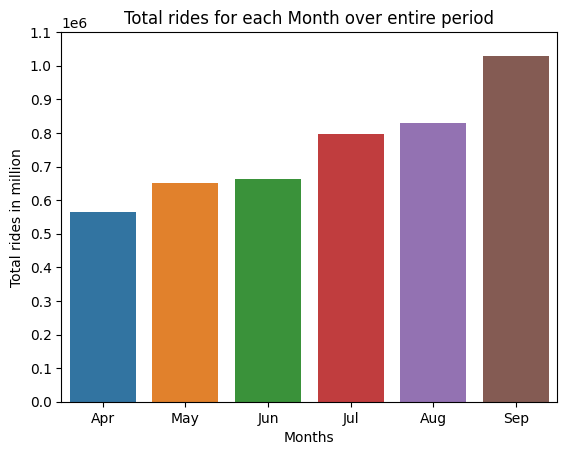

In [7]:
# Get and sort monthly ride counts
monthly_counts = data.Month.value_counts()
monthly_counts.sort_values(ascending=True, inplace=True)

# Make plot
sns.barplot(x=monthly_counts.index, y=monthly_counts.values)
plt.xlabel('Months')
plt.ylabel('Total rides in million')
plt.yticks(np.arange(0,1200000, 100000))
plt.title('Total rides for each Month over entire period')
plt.show()

In [8]:
weekly_rides = data.groupby(['Week of year'])['Rides'].sum()

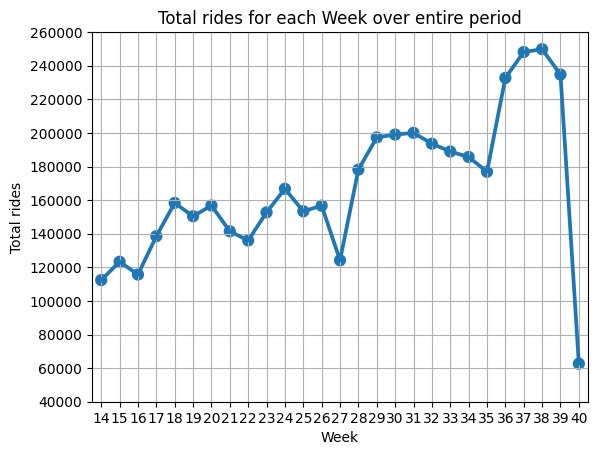

In [9]:
# Make plot
sns.pointplot(x=weekly_rides.index, y=weekly_rides.values)
plt.xlabel('Week')
plt.ylabel('Total rides')
plt.yticks(np.arange(40000,270000, 20000))
plt.title('Total rides for each Week over entire period')
plt.grid()
plt.show()

week 40 was not complete and the data ends on the tuesday, therefore we do not have enough data to complete the month and will drop this week. We also have to take a look at week 27 to try and see what happened there.

In [10]:
data.drop(data.index[data['Week of year'] == 40], inplace=True)

In [11]:
# Get data for week 27
week27 = data[data['Week of year']==27]

In [12]:
# View what month it was
week27.Month.unique()

array(['Jun', 'Jul'], dtype=object)

In [13]:
# View the day of months
week27.Day.value_counts().sort_index()

Day
1     21228
2     26480
3     21597
4     14148
5     10890
6     11443
30    18395
Name: count, dtype: int64

from the above information it is clear that during the 4th - 6th of July the amount of rides was really low. When searching google for what happened on these days, it is apparent that the USA celebrated Independence day on the 4th of july which was a Friday, then the 5th and 6th of July was Saturday and Sunday when the majority of NYC celebrated their Independence day. Therefore we cannot ignore this data, and will simply have to take it as white noise.

These are Uber's bases located in New York. Each uber pickup is affiliated with a TLC (Taxi and Limousine Commission) company base. 
https://github.com/shoninouye/DataVisualization_Uber_R

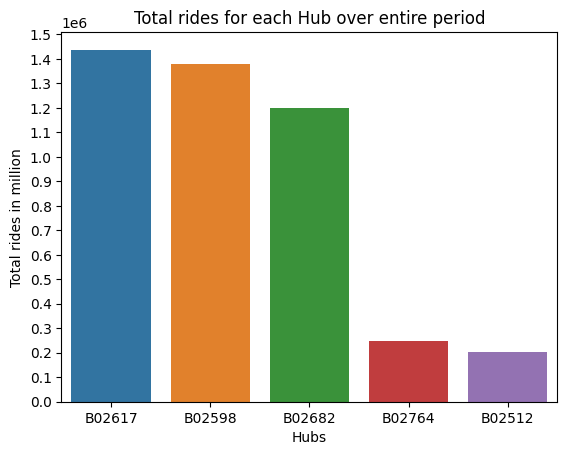

In [14]:
ride_counts = data.Base.value_counts()
sns.barplot(x=ride_counts.index, y=ride_counts.values)
plt.xlabel('Hubs')
plt.ylabel('Total rides in million')
plt.yticks(np.arange(0,1600000, 100000))
plt.title('Total rides for each Hub over entire period')
plt.show()

In [15]:
# Create variable that has the total sum of each week of the entire period
week_of_year = data.groupby(['Base', 'Week of year'])['Rides'].sum().reset_index()

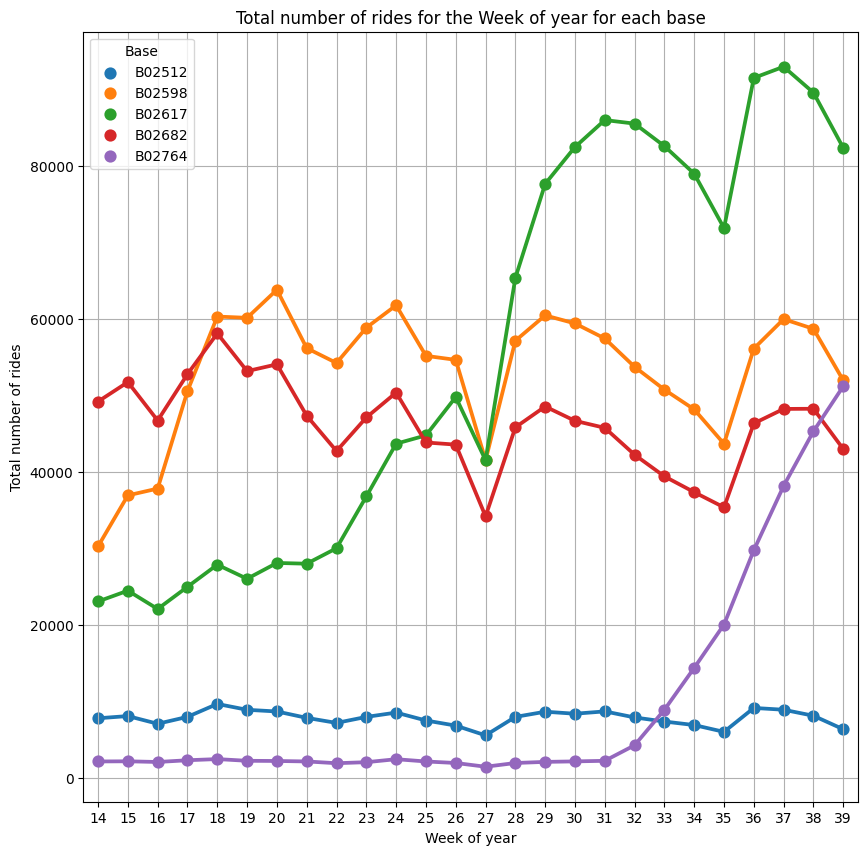

In [16]:
# Initialize figure
fig, ax = plt.subplots(figsize=(10,10))
# Specify graph
sns.pointplot(x='Week of year', y='Rides', hue='Base', data=week_of_year, ax=ax)
# Add details
plt.title('Total number of rides for the Week of year for each base')
plt.ylabel('Total number of rides')
# Show grid
plt.grid()
# Show figure
plt.show()

### Analysis

In [17]:
# Create variable that has the total sum of each day of the month
day_of_week = data.groupby(['Base', 'Day of Week'])['Rides'].sum().reset_index()

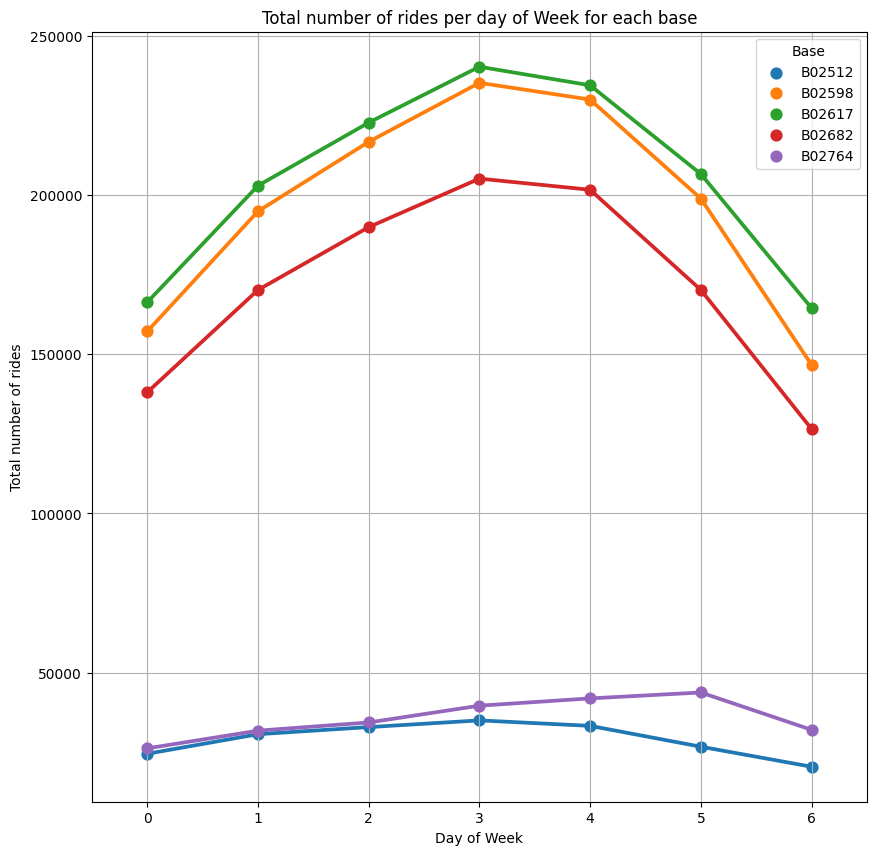

In [18]:
# Initialize figure
fig, ax = plt.subplots(figsize=(10,10))
# Specify graph
sns.pointplot(x='Day of Week', y='Rides', hue='Base', data=day_of_week, ax=ax)
# Add details
plt.title('Total number of rides per day of Week for each base')
plt.ylabel('Total number of rides')
# Show grid
plt.grid()
# Show figure
plt.show()

In [19]:
# Create variable containing total number of rides per hour over entire month for each base
hours = data.groupby(['Base', 'Hour'])['Rides'].sum().reset_index()

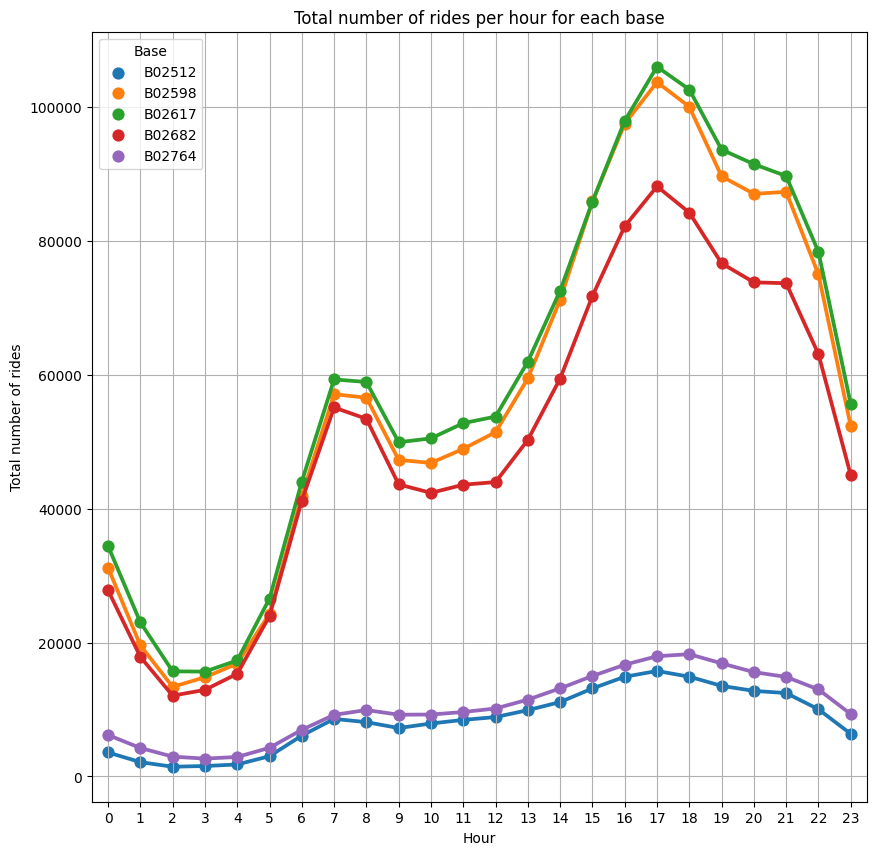

In [20]:
# Initialize figure
fig, ax = plt.subplots(figsize=(10,10))
# Specify graph
sns.pointplot(x='Hour', y='Rides', hue='Base', data=hours, ax=ax)
# Add details
plt.title('Total number of rides per hour for each base')
plt.ylabel('Total number of rides')
# Show grid
plt.grid()
# Show figure
plt.show()

### Analysis

Maak groups volgens elke uur van die dag.

maak die groupins volgens knn en dan plot sirkels volgens die avg lat en long

kry die total rides van verskillende plekke en maap heatmap om te sien waar die meeste rides gebeur, heatmap verander soos wat uur verander van user input

### Weekdays vs Weekends

In [21]:
# Create variable containing total number of rides per hour over entire month for each base
total_week_hours = data[data['Day of Week'] < 5].groupby(['Hour'])['Rides'].sum().reset_index()
total_weekend_hours = data[data['Day of Week'] > 4].groupby(['Hour'])['Rides'].sum().reset_index()

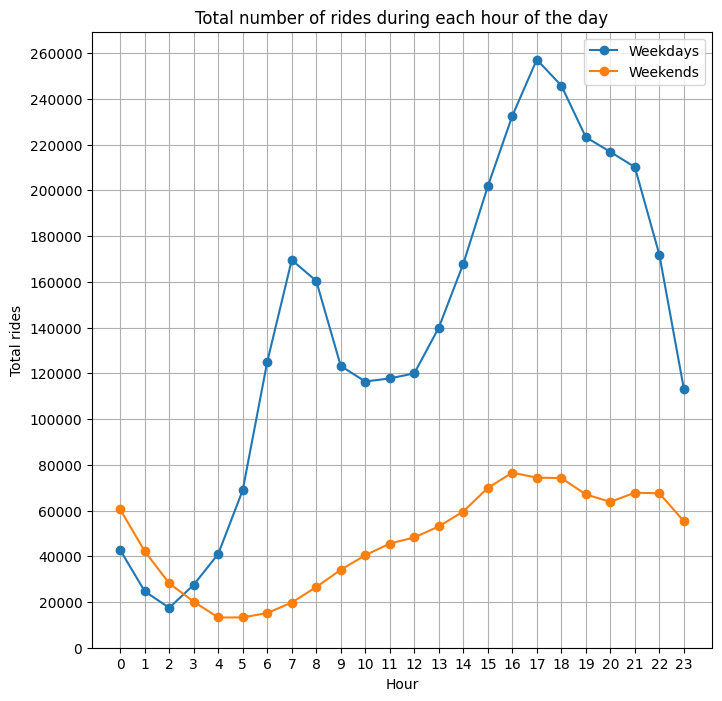

In [22]:
plt.figure(figsize=(8,8))

plt.plot(total_week_hours['Hour'], total_week_hours['Rides'], label='Weekdays', marker='o')
plt.plot(total_weekend_hours['Hour'], total_weekend_hours['Rides'], label='Weekends', marker='o')

plt.title('Total number of rides during each hour of the day')
plt.xlabel('Hour')
plt.ylabel('Total rides')
plt.xticks(np.arange(0,24,1))
plt.yticks(np.arange(0,261000,20000))
plt.legend()
plt.grid()
plt.show()

it is clear that there is a much higer need for rides during the week than the weekend. This is probably because we have 5 week days and only 2 days on the weekend. So in order to have a fair comparison, I will normalize the data by using a StandardScaler and replot it below.

In [23]:
# Initialize a Standard scaler.
sc = StandardScaler()
# Scale the data
total_week_hours['Rides'] = sc.fit_transform(total_week_hours[['Rides']])
total_weekend_hours['Rides'] = sc.fit_transform(total_weekend_hours[['Rides']])

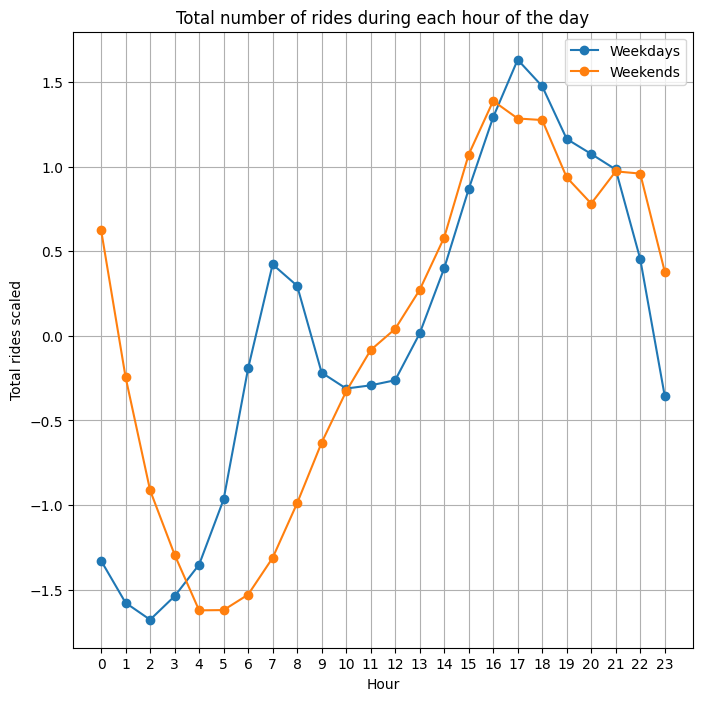

In [24]:
plt.figure(figsize=(8,8))

plt.plot(total_week_hours['Hour'], total_week_hours['Rides'], label='Weekdays', marker='o')
plt.plot(total_weekend_hours['Hour'], total_weekend_hours['Rides'], label='Weekends', marker='o')

plt.title('Total number of rides during each hour of the day')
plt.xlabel('Hour')
plt.ylabel('Total rides scaled')
plt.xticks(np.arange(0,24,1))
plt.legend()
plt.grid()
plt.show()

it is clear that weekend rides are much more during the hours of 10 pm and 1 am, where as weekday rides are much higher during the hours of 5 am - 8 am. Both Weekdays and Weekends have a daily peak at around 4 pm - 6 pm.

In [25]:
# Create variable containing total number of rides per hour over entire month for each base
week_hours = data[data['Day of Week'] < 5].groupby(['Base', 'Hour'])['Rides'].sum().reset_index()

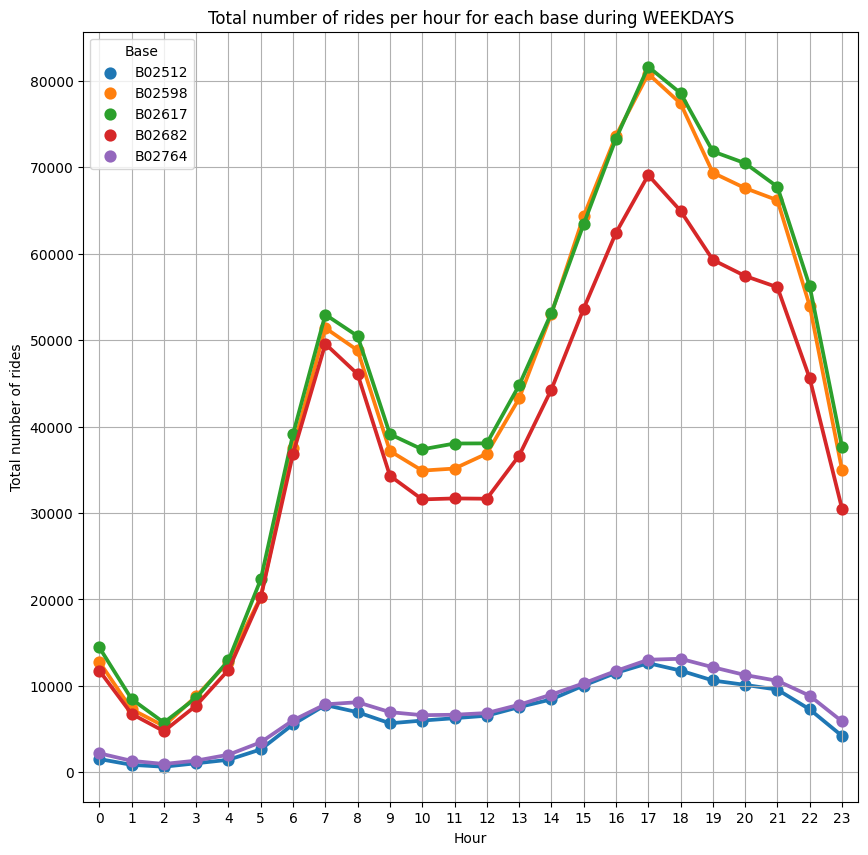

In [26]:
# Initialize figure
fig, ax = plt.subplots(figsize=(10,10))
# Specify graph
sns.pointplot(x='Hour', y='Rides', hue='Base', data=week_hours, ax=ax)
# Add details
plt.title('Total number of rides per hour for each base during WEEKDAYS')
plt.ylabel('Total number of rides')
# Show grid
plt.grid()
# Show figure
plt.show()

increase from 5 am to 8 am then agian from 3 pm to 9 pm during weekdays

In [27]:
# Create variable containing total number of rides per hour over entire month for each base
weekend_hours = data[data['Day of Week'] > 4].groupby(['Base', 'Hour'])['Rides'].sum().reset_index()

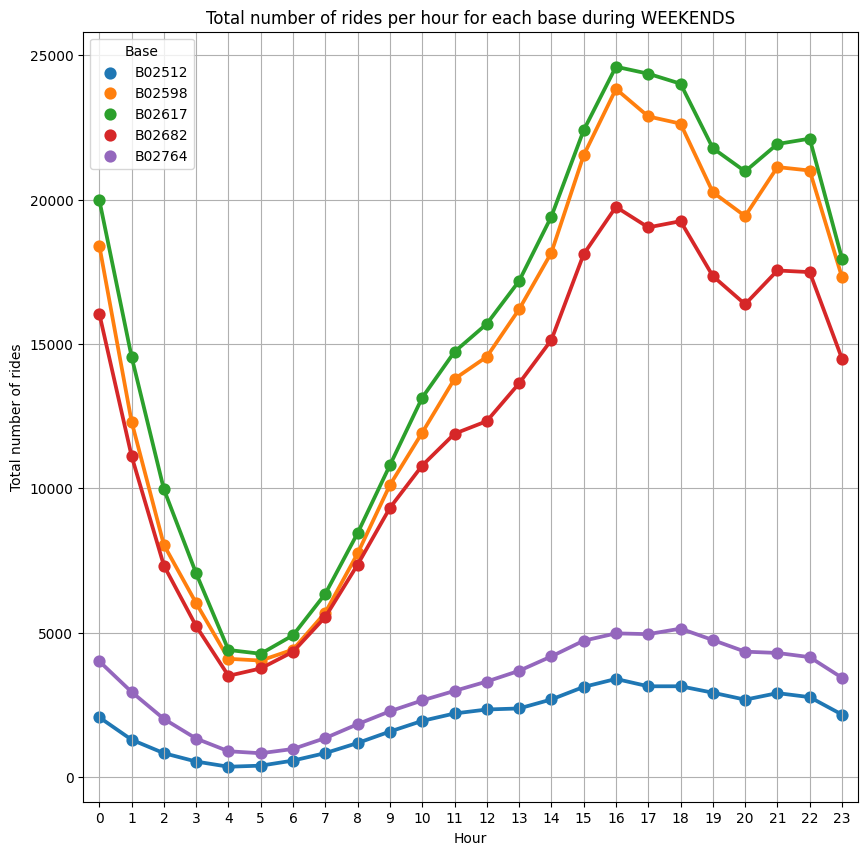

In [28]:
# Initialize figure
fig, ax = plt.subplots(figsize=(10,10))
# Specify graph
sns.pointplot(x='Hour', y='Rides', hue='Base', data=weekend_hours, ax=ax)
# Add details
plt.title('Total number of rides per hour for each base during WEEKENDS')
plt.ylabel('Total number of rides')
# Show grid
plt.grid()
# Show figure
plt.show()

increase from 2 pm to 12 pm on weekends

## Clustering

In [29]:
# Create dataset for clustering
X = data[['Lat', 'Lon']].copy()
# Transfrom dataframe to expand values so it will be easier for clustering
X = X *1000

X.head()

Lat      Lon
0  40769.0 -73954.9
1  40726.7 -74034.5
2  40731.6 -73987.3
3  40758.8 -73977.6
4  40759.4 -73972.2

In [30]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X)

C:\Users\erikn\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

In [31]:
clusters = kmeans.predict(X)
clusters

array([5, 9, 9, ..., 4, 3, 3])

In [32]:
type(clusters)

numpy.ndarray

In [33]:
len(clusters)

4471695

In [34]:
data['Cluster'] = clusters

In [35]:
data.head()

Date/Time      Lat      Lon    Base  Rides        Date Month  Day   
0 2014-04-01 00:11:00  40.7690 -73.9549  B02512      1  2014-04-01   Apr    1  \
1 2014-04-01 00:17:00  40.7267 -74.0345  B02512      1  2014-04-01   Apr    1   
2 2014-04-01 00:21:00  40.7316 -73.9873  B02512      1  2014-04-01   Apr    1   
3 2014-04-01 00:28:00  40.7588 -73.9776  B02512      1  2014-04-01   Apr    1   
4 2014-04-01 00:33:00  40.7594 -73.9722  B02512      1  2014-04-01   Apr    1   

   Hour  Day of Week  Week of year  Cluster  
0     0            1            14        5  
1     0            1            14        9  
2     0            1            14        9  
3     0            1            14        1  
4     0            1            14        1

In [36]:
cluster_weeks = data.groupby(['Cluster', 'Week of year'])['Rides'].sum().reset_index()
cluster_hours = data.groupby(['Cluster', 'Hour'])['Rides'].sum().reset_index()

se net cluster nommer, die kleur en waar op die map dit is

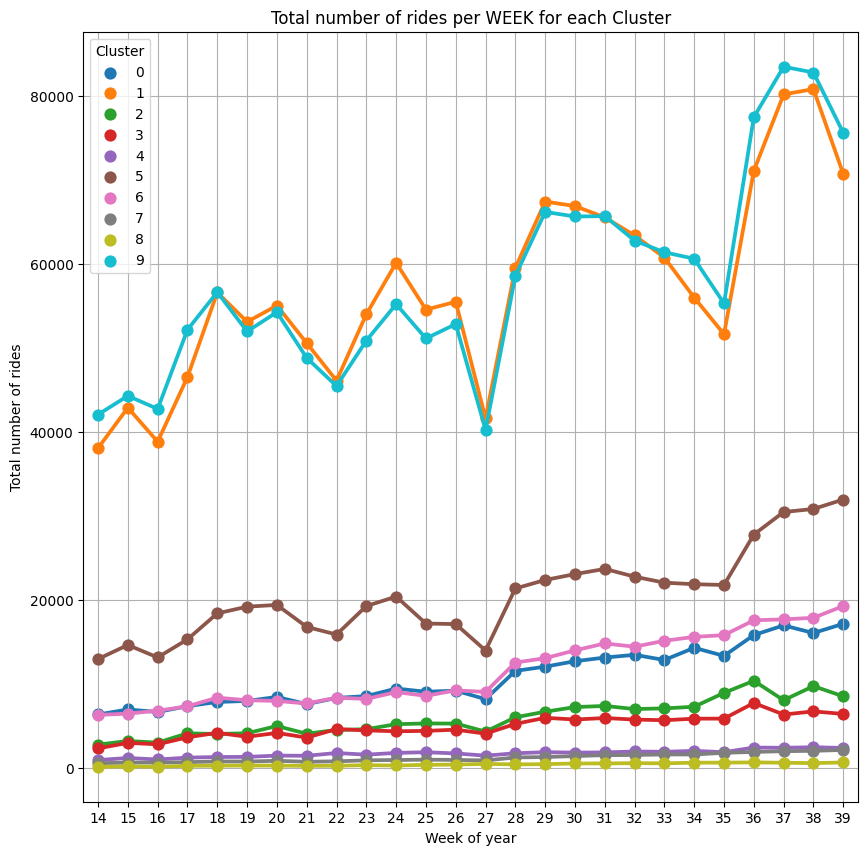

In [37]:
# Initialize figure
fig, ax = plt.subplots(figsize=(10,10))
# Specify graph
sns.pointplot(x='Week of year', y='Rides', hue='Cluster', data=cluster_weeks, ax=ax)
# Add details
plt.title('Total number of rides per WEEK for each Cluster')
plt.ylabel('Total number of rides')
# Show grid
plt.grid()
# Show figure
plt.show()

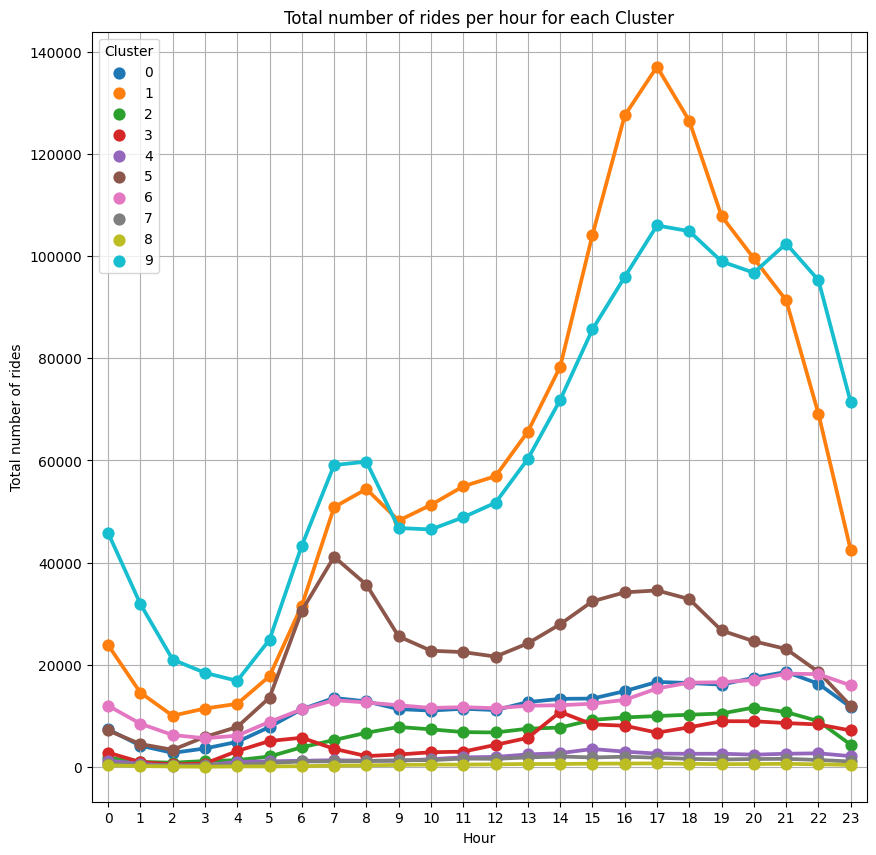

In [38]:
# Initialize figure
fig, ax = plt.subplots(figsize=(10,10))
# Specify graph
sns.pointplot(x='Hour', y='Rides', hue='Cluster', data=cluster_hours, ax=ax)
# Add details
plt.title('Total number of rides per hour for each Cluster')
plt.ylabel('Total number of rides')
# Show grid
plt.grid()
# Show figure
plt.show()

orange - midtown

blue - lower manhatten

brown - manhatten

# doen:
maak forecasts vir volgende week, asook forecasts vir weekdays en weekends, en dalk forecasts spesifiek vir elke dag

In [39]:
data

Date/Time      Lat      Lon    Base  Rides        Date   
0       2014-04-01 00:11:00  40.7690 -73.9549  B02512      1  2014-04-01  \
1       2014-04-01 00:17:00  40.7267 -74.0345  B02512      1  2014-04-01   
2       2014-04-01 00:21:00  40.7316 -73.9873  B02512      1  2014-04-01   
3       2014-04-01 00:28:00  40.7588 -73.9776  B02512      1  2014-04-01   
4       2014-04-01 00:33:00  40.7594 -73.9722  B02512      1  2014-04-01   
...                     ...      ...      ...     ...    ...         ...   
4520329 2014-09-28 23:57:00  40.6447 -73.7821  B02764      1  2014-09-28   
4520330 2014-09-28 23:57:00  40.7513 -73.9941  B02764      1  2014-09-28   
4520331 2014-09-28 23:57:00  40.6875 -74.1824  B02764      1  2014-09-28   
4520332 2014-09-28 23:57:00  40.6482 -73.7823  B02764      1  2014-09-28   
4520333 2014-09-28 23:59:00  40.6483 -73.7824  B02764      1  2014-09-28   

        Month  Day  Hour  Day of Week  Week of year  Cluster  
0         Apr    1     0            1            14        5  
1         Apr    1     0            1            14        9  
2         Apr    1     0            1            14        9  
3         Apr    1     0            1            14        1  
4         Apr    1     0            1            14        1  
...       ...  ...   ...          ...           ...      ...  
4520329   Sep   28    23            6            39        3  
4520330   Sep   28    23            6            39        1  
4520331   Sep   28    23            6            39        4  
4520332   Sep   28    23            6            39        3  
4520333   Sep   28    23            6            39        3  

[4471695 rows x 12 columns]

In [40]:
day_vehicles = data.groupby(['Date'])['Rides'].sum().reset_index()
day_vehicles['Date'] = pd.to_datetime(day_vehicles['Date'])
day_vehicles.set_index('Date', inplace=True)

week_vehicles = data.groupby(['Week of year'])['Rides'].sum().reset_index()
#week_vehicels['Date']

decompose_result_mult_day = seasonal_decompose(day_vehicles, model="multiplicative")

trend_day = decompose_result_mult_day.trend
seasonal_day = decompose_result_mult_day.seasonal
residual_day = decompose_result_mult_day.resid

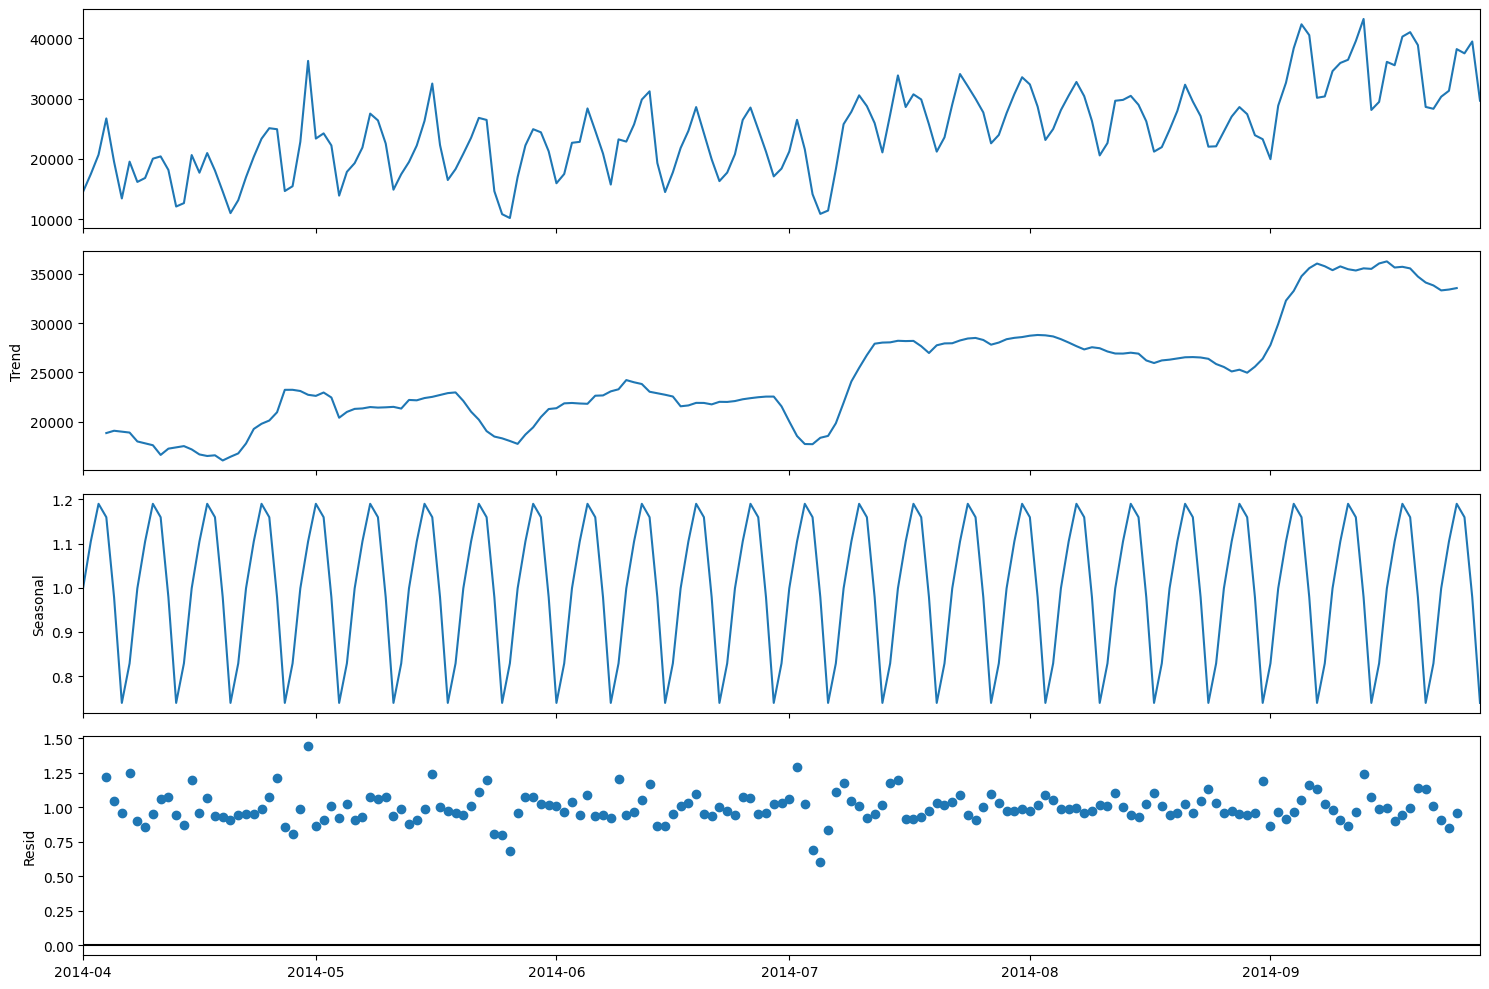

In [41]:
fig = decompose_result_mult_day.plot()

fig.set_size_inches((15, 10))
fig.tight_layout()
plt.show()

forecast volgende 7 dae

doen hourly en weekly decompose

## Hourly decompose

In [42]:
resample_df = data.copy()
resample_df.set_index('Date/Time', inplace=True)
hourly_rides = resample_df.resample('H')['Rides'].sum().reset_index().set_index('Date/Time')

decompose_result_mult_hour = seasonal_decompose(hourly_rides, model="multiplicative")

trend_hour= decompose_result_mult_hour.trend
seasonal_hour = decompose_result_mult_hour.seasonal
residual_hour = decompose_result_mult_hour.resid

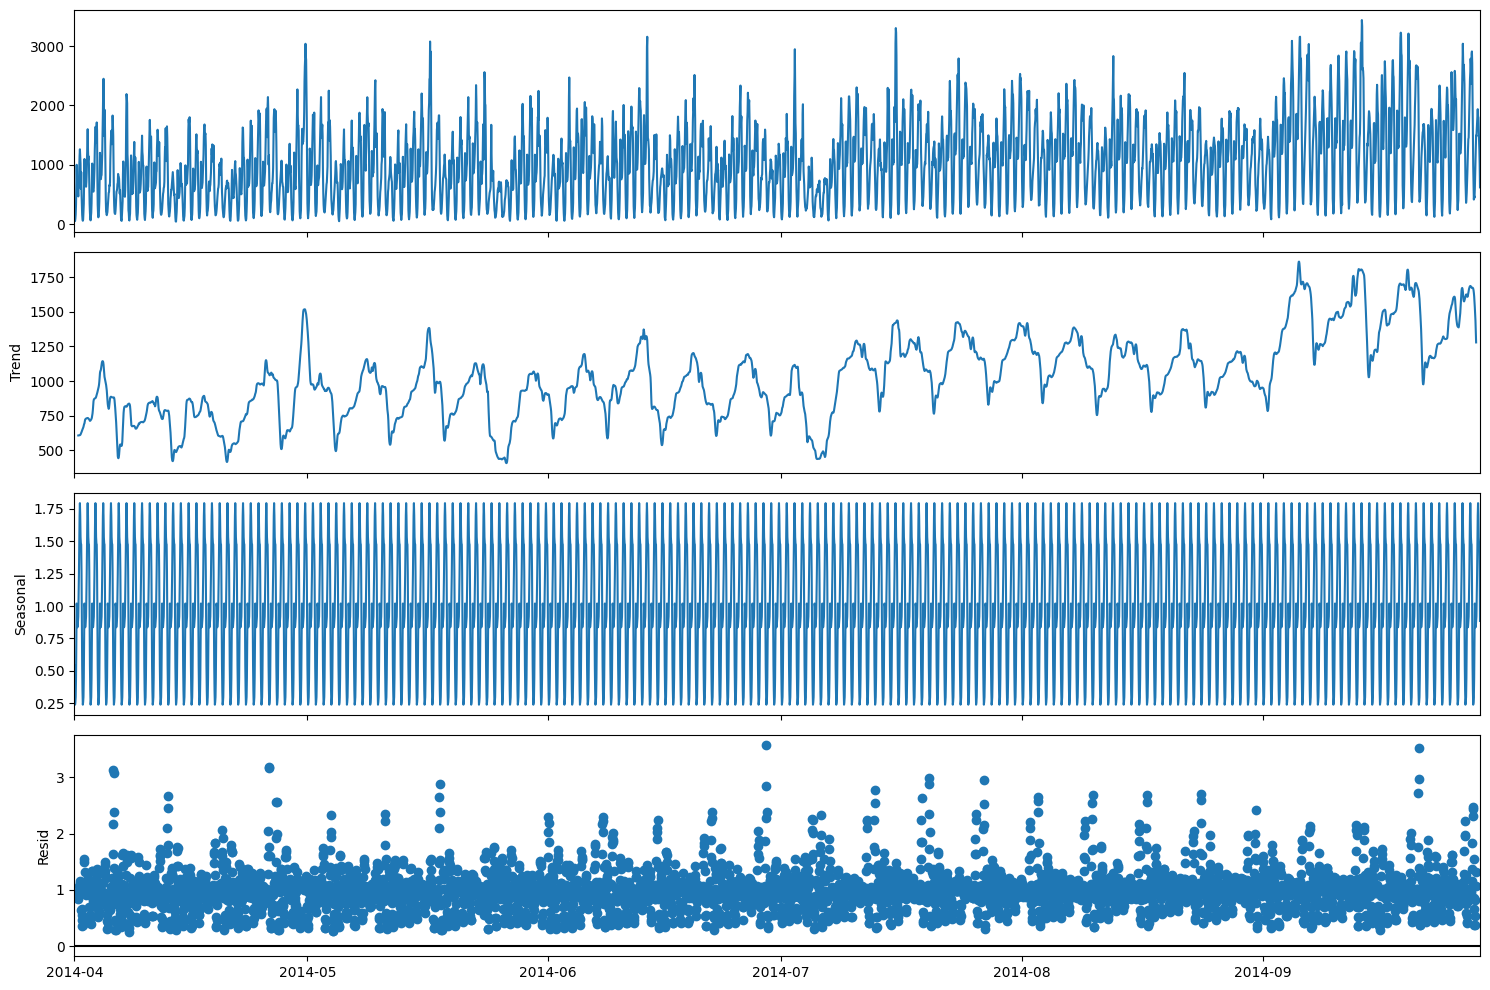

In [43]:
fig = decompose_result_mult_hour.plot()

fig.set_size_inches((15, 10))
fig.tight_layout()
plt.show()

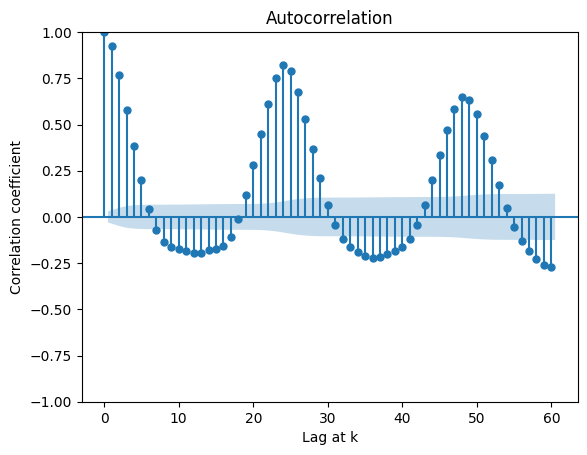

In [44]:
# Stands for Time Series Analysis Plots (TSA Plots)
fig = tsaplots.plot_acf(hourly_rides['Rides'], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

indicating seasonality, therefore we can use sarimax

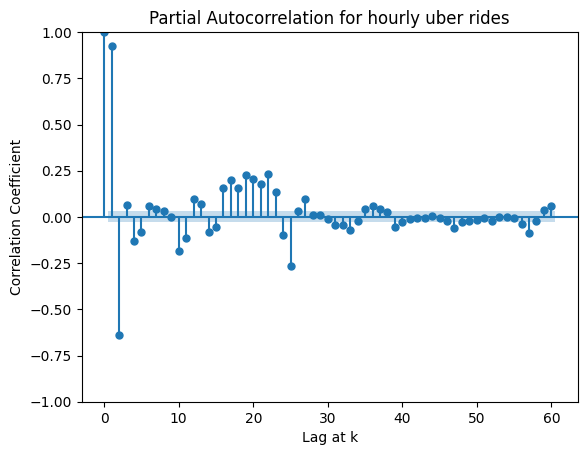

In [45]:
fig = tsaplots.plot_pacf(hourly_rides['Rides'], lags=60)

plt.title("Partial Autocorrelation for hourly uber rides")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

In [46]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 1, 0, 24)
SARIMAX: (0, 1, 0) x (0, 1, 1, 24)
SARIMAX: (0, 1, 0) x (1, 0, 0, 24)


In [47]:
hourly_rides.shape[0] 

4344

In [48]:
# specify to ignore warning messages, these warnings will appear if model is unable to fit to data with the specified paramters
warnings.filterwarnings("ignore") 

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(hourly_rides['Rides'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:74029.95332771246
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:69565.6686312803
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:63648.84287644535
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:63646.07643537883
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:63945.807475126494
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:63947.75254666774
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:63648.486890918066
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:62537.857032071995
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:68586.07789421052
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:64801.295871901675
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:59828.82301199957
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:59210.80490148284
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:60065.42014154843
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:59774.15738942583
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:58548.89298277979
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:60165.80596947236
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:58235.51513315855
ARIMA(0, 1, 0)x(0, 1, 0, 24)12 - AIC:57623.17158300924
ARIMA(0

In [54]:
mod = sm.tsa.statespace.SARIMAX(hourly_rides['Rides'],order=(1, 1, 1), seasonal_order=(1, 1, 1, 24), freq='H')

results = mod.fit(max_iter=100)

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1063      0.011     10.106      0.000       0.086       0.127
ma.L1          0.2846      0.011     25.160      0.000       0.262       0.307
ar.S.L24       0.9999   3.31e-05   3.02e+04      0.000       1.000       1.000
ma.S.L24      -0.9820      0.003   -300.836      0.000      -0.988      -0.976
sigma2      2.348e+04    292.589     80.252      0.000    2.29e+04    2.41e+04


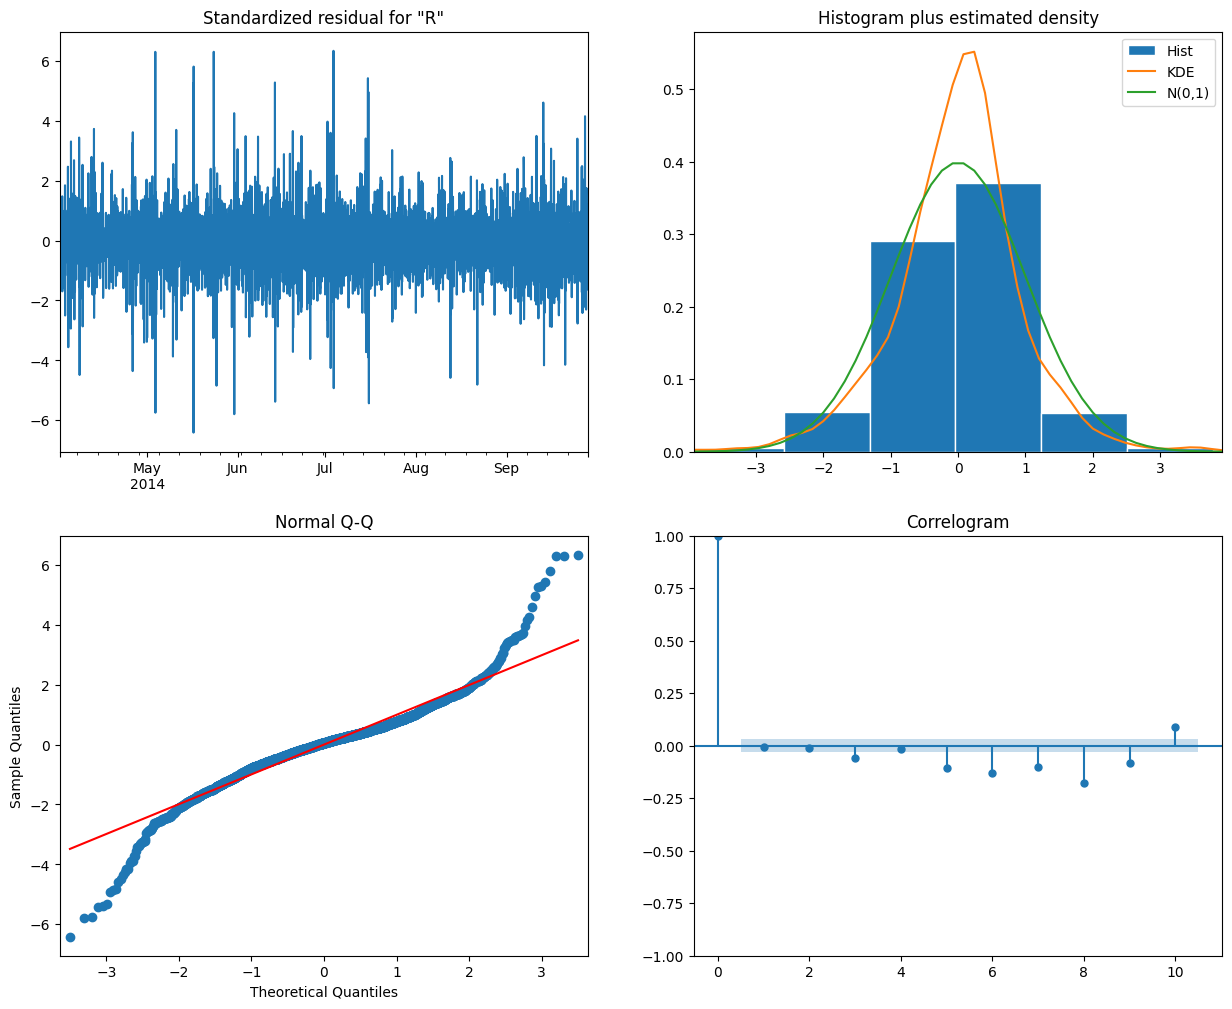

In [55]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [56]:
results.aic

56094.33380261842

In [57]:
results.bic

56126.2154057811

In [58]:
np.sqrt(results.mse)

154.1560843268938

vals: 0,1,2, 2,1,1,24     -   aic= 55142

vals: 

In [57]:
results.conf_int()

0             1
ma.L1         0.255627      0.289886
ma.L2         0.003712      0.043105
ar.S.L24      0.787849      0.899231
ar.S.L48     -0.428405     -0.380756
ma.S.L24     -1.586648     -1.471240
ma.S.L48      0.510441      0.621691
sigma2    19699.878449  20646.283161

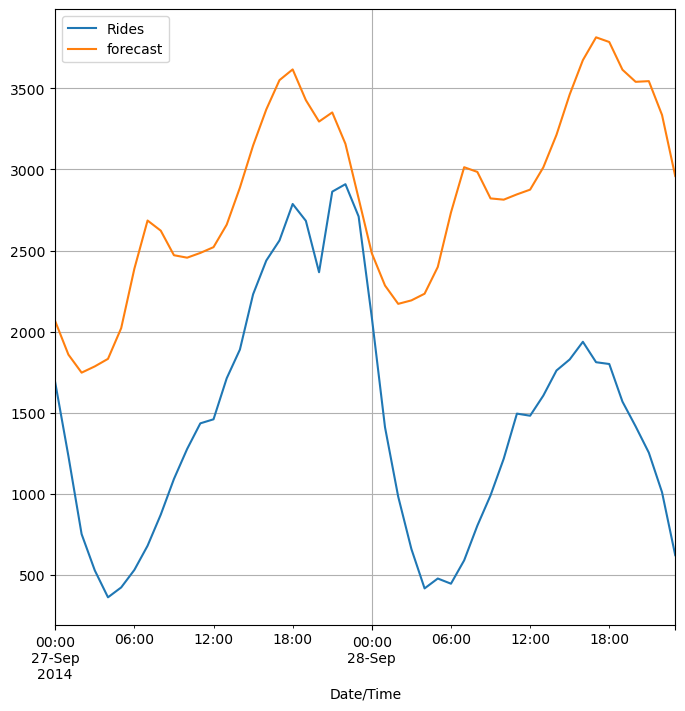

In [58]:
hourly_rides['forecast'] = results.predict(start=4296, end=4344, dynamic=True)
hourly_rides[['Rides', 'forecast']][4296:].plot(figsize=(8,8))
plt.grid()

In [56]:
hourly_rides.tail()

Rides     forecast
Date/Time                              
2014-09-28 19:00:00   1568  3701.505298
2014-09-28 20:00:00   1415  3521.134634
2014-09-28 21:00:00   1253  3340.843826
2014-09-28 22:00:00   1009  3069.806047
2014-09-28 23:00:00    621  2603.042476

probeer prophet

In [1]:
import fbprophet

ModuleNotFoundError: No module named 'fbprophet'

### data for maps

In [601]:
cluster_location = data.groupby(['Cluster'])['Lat', 'Lon'].mean()

C:\Users\Erik\AppData\Local\Temp\ipykernel_7100\1611671311.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_location = data.groupby(['Cluster'])['Lat', 'Lon'].mean()


In [603]:
cl1_data = data[data['Cluster'] == 0][['Lat','Lon']][:500]
cl2_data = data[data['Cluster'] == 1][['Lat','Lon']][:500]
cl3_data = data[data['Cluster'] == 2][['Lat','Lon']][:500]
cl4_data = data[data['Cluster'] == 3][['Lat','Lon']][:500]
cl5_data = data[data['Cluster'] == 4][['Lat','Lon']][:500]
cl6_data = data[data['Cluster'] == 5][['Lat','Lon']][:500]
cl7_data = data[data['Cluster'] == 6][['Lat','Lon']][:500]
cl8_data = data[data['Cluster'] == 7][['Lat','Lon']][:500]
cl9_data = data[data['Cluster'] == 8][['Lat','Lon']][:500]
cl10_data = data[data['Cluster'] == 9][['Lat','Lon']][:500]

In [605]:
map_data = pd.concat([cl1_data, cl2_data, cl3_data, cl4_data, cl5_data, cl6_data, cl7_data, cl8_data, cl9_data, cl10_data])

In [607]:
cl_1 = cluster_location.loc[0]
cl_2 = cluster_location.loc[1]
cl_3 = cluster_location.loc[2]
cl_4 = cluster_location.loc[3]
cl_5 = cluster_location.loc[4]
cl_6 = cluster_location.loc[5]
cl_7 = cluster_location.loc[6]
cl_8 = cluster_location.loc[7]
cl_9 = cluster_location.loc[8]
cl_10 = cluster_location.loc[9]

## Map

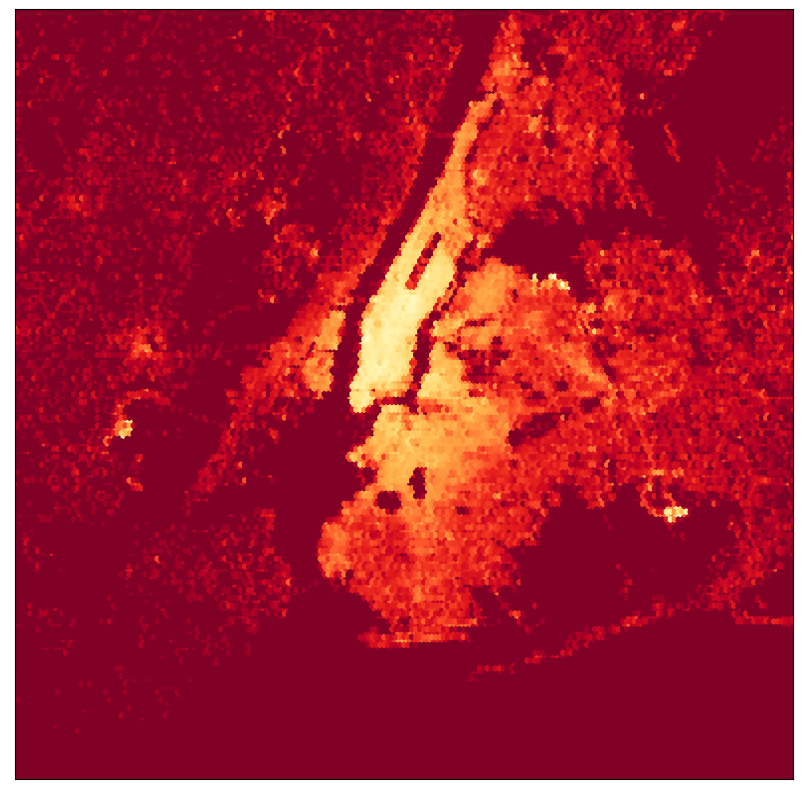

In [608]:
west, south, east, north = -74.26, 40.50, -73.70, 40.92

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='i')
x, y = m(data['Lon'].values, data['Lat'].values)
m.hexbin(x, y, gridsize=1000,bins='log', cmap='YlOrRd_r')

In [609]:
# Use part of the dataset (first 5 samples) to illustrate visualization!
dataSample = data[0:200]

In [610]:
m = folium.Map(location = [40.73, -74], tiles ='OpenStreetMap', zoom_start=11)
markerCluster = MarkerCluster().add_to(m)

In [611]:
for i,row in map_data.iterrows():
    lat = map_data.at[i, 'Lat']
    lng = map_data.at[i, 'Lon']
    
    #print(lat, lng)
    
    folium.Marker(location=[lat,lng], icon = folium.Icon(color='blue')).add_to(markerCluster)
    
# Make circle locations on map according to the clusters created above, average center location. This will draw 10 circles.
folium.Circle(radius=2000,location=[cl_1[0], cl_1[1]],color='darkblue',fill=False,).add_to(m)
folium.Circle(radius=2000,location=[cl_2[0], cl_2[1]],color='orange',fill=False,).add_to(m)
folium.Circle(radius=2000,location=[cl_3[0], cl_3[1]],color='darkgreen',fill=False,).add_to(m)
folium.Circle(radius=2000,location=[cl_4[0], cl_4[1]],color='red',fill=False,).add_to(m)
folium.Circle(radius=2000,location=[cl_5[0], cl_5[1]],color='purple',fill=False,).add_to(m)
folium.Circle(radius=2000,location=[cl_6[0], cl_6[1]],color='brown',fill=False,).add_to(m)
folium.Circle(radius=2000,location=[cl_7[0], cl_7[1]],color='pink',fill=False,).add_to(m)
folium.Circle(radius=2000,location=[cl_8[0], cl_8[1]],color='gray',fill=False,).add_to(m)
folium.Circle(radius=2000,location=[cl_9[0], cl_9[1]],color='lightgreen',fill=False,).add_to(m)
folium.Circle(radius=2000,location=[cl_10[0], cl_10[1]],color='lightblue',fill=False,).add_to(m)

In [612]:
m